## Prepare the workspace

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='data/assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

### Import Libraries and Define Device

In [1]:
# PyTorch imports for neural networks and optimization
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models

# Utility libraries for data manipulation and visualization
import numpy as np
from collections import OrderedDict

# Inline plotting for Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Matplotlib for plotting and PIL for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# OS and utility libraries for file handling and randomness
import os
import glob
import time
import random
import json
from pathlib import Path

In [2]:
# Check torch version and CUDA status if GPU is enabled.
print("PyTorch version is: {}".format(torch.__version__))
print("Is GUP enabled for PyTorch: {}".format(torch.cuda.is_available())) # Should return True when GPU is enabled.

PyTorch version is: 2.5.1+cu121
Is GUP enabled for PyTorch: True


In [3]:
def get_current_working_directory():
    """
    Retrieves the absolute path of the current working directory.

    Returns:
        pathlib.Path: A Path object representing the current working directory.
    """
    # Get and return the resolved absolute path of the current working directory
    return Path().resolve()

# Get the current working directory
base_dir = get_current_working_directory()

# Print the current working directory for verification
print(f"Current working directory: {base_dir}")

Current working directory: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
<mark>The dataset is split into three parts, training, validation, and testing.</mark> For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1. **why?**

Pre-trained models (like VGG16, ResNet) are trained on the ImageNet dataset. This means they expect input images to be processed in a way that matches how they were trained. Normalization involves adjusting the pixel values in each color channel (Red, Green, Blue) of an image to have specific mean and standard deviation values. This adjustment helps ensure consistency in input, allowing the model to perform better.

### Define Data Loaders and Image Transformations

In [4]:
def define_dataset_paths(base_directory):
    """
    Constructs dataset directory paths for training, validation, and testing.

    Args:
        base_directory (str or pathlib.Path): Base directory containing the dataset.

    Returns:
        tuple: Paths for the training, validation, and testing directories.
    """
    train_dir = os.path.join(base_directory, "data", "flowers", "train")
    valid_dir = os.path.join(base_directory, "data", "flowers", "valid")
    test_dir = os.path.join(base_directory, "data", "flowers", "test")
    return train_dir, valid_dir, test_dir

# Define dataset paths using the base directory
train_dir, valid_dir, test_dir = define_dataset_paths(base_dir)

In [5]:
def get_testing_transforms():
    """
    Returns the standard image transforms for validation and testing datasets.

    Returns:
        torchvision.transforms.Compose: A composed set of image transformations.
    """
    return transforms.Compose([
        transforms.Resize(255),  # Resize image to a shorter side of 255 pixels
        transforms.CenterCrop(224),  # Crop the image at the center to 224x224
        transforms.ToTensor(),  # Convert image to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ])

In [6]:
def load_datasets(train_dir, valid_dir, test_dir):
    """
    Defines image transforms and loads datasets for training, validation, and testing.

    Args:
        train_dir (str): Path to the training dataset.
        valid_dir (str): Path to the validation dataset.
        test_dir (str): Path to the testing dataset.

    Returns:
        tuple: Training, validation, and testing datasets.
    """
    # Define training transforms with data augmentation
    training_transforms = transforms.Compose([
        transforms.RandomRotation(30),  # Randomly rotate the image
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert image to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ])

    # Define validation and testing transforms
    validation_transforms = get_testing_transforms()
    testing_transforms = get_testing_transforms()

    # Load datasets using torchvision's ImageFolder
    training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
    validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
    testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

    # Ensure consistent class_to_idx across all datasets
    class_to_idx = training_dataset.class_to_idx  # Use training dataset's class_to_idx
    validation_dataset.class_to_idx = class_to_idx
    testing_dataset.class_to_idx = class_to_idx

    return training_dataset, validation_dataset, testing_dataset

# Load datasets
training_dataset, validation_dataset, testing_dataset = load_datasets(
    train_dir, valid_dir, test_dir
)

In [7]:
def print_class_indices(training_dataset, validation_dataset, testing_dataset):
    """
    Prints the class indices for training, validation, and testing datasets.

    Args:
        training_dataset (ImageFolder): Training dataset.
        validation_dataset (ImageFolder): Validation dataset.
        testing_dataset (ImageFolder): Testing dataset.
    """
    print("Training dataset class indices:\n{}".format(training_dataset.class_to_idx))
    print("\nValidation dataset class indices:\n{}".format(validation_dataset.class_to_idx))
    print("\nTesting dataset class indices:\n{}".format(testing_dataset.class_to_idx))

# Print class indices
print_class_indices(training_dataset, validation_dataset, testing_dataset)

Training dataset class indices:
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96

In [8]:
def create_dataloaders(training_dataset, validation_dataset, testing_dataset, batch_size=64):
    """
    Creates PyTorch dataloaders for training, validation, and testing datasets.

    Args:
        training_dataset (ImageFolder): Training dataset.
        validation_dataset (ImageFolder): Validation dataset.
        testing_dataset (ImageFolder): Testing dataset.
        batch_size (int, optional): Number of samples per batch. Defaults to 64.

    Returns:
        tuple: Dataloaders for training, validation, and testing datasets.
    """
    # Create training dataloader with shuffling to improve generalization
    trainingloader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True
    )
    print(
        "Training loader has {} batches, and each batch has {} samples".format(
            len(trainingloader), batch_size
        )
    )

    # Create validation dataloader without shuffling
    # Shuffling isn't necessary as the order of examples doesn't matter for validation
    validationloader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size
    )
    print(
        "Validation loader has {} batches, and each batch has {} samples".format(
            len(validationloader), batch_size
        )
    )

    # Create testing dataloader without shuffling
    # The testing dataset is used once at the end to evaluate the model
    testingloader = torch.utils.data.DataLoader(
        testing_dataset, batch_size=batch_size
    )
    print(
        "Testing loader has {} batches, and each batch has {} samples".format(
            len(testingloader), batch_size
        )
    )

    return trainingloader, validationloader, testingloader


# Define batch size
batch_size = 64

# Create dataloaders for training, validation, and testing datasets
trainingloader, validationloader, testingloader = create_dataloaders(
    training_dataset, validation_dataset, testing_dataset, batch_size=batch_size
)

Training loader has 103 batches, and each batch has 64 samples
Validation loader has 13 batches, and each batch has 64 samples
Testing loader has 13 batches, and each batch has 64 samples


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
def load_category_mapping(mapping_file_path):
    """
    Loads the category-to-name mapping from a JSON file and prints it in order.

    Args:
        mapping_file_path (str): Path to the JSON file containing the category-to-name mapping.

    Returns:
        dict: Ordered dictionary mapping category indices to their respective names.
    """
    # Open and load the JSON file containing category-to-name mapping
    with open(mapping_file_path, 'r') as f:
        cat_to_name = json.load(f)

    # Create an ordered dictionary sorted by the keys
    ordered_cat_to_name = OrderedDict(sorted(cat_to_name.items(), key=lambda x: int(x[0])))

    # Log the type and ordered contents of the mapping for verification
    print("Type of cat_to_name is: {}".format(type(ordered_cat_to_name)))
    print("cat_to_name is:")
    for key, value in ordered_cat_to_name.items():
        print("  {}: {}".format(key, value))

    return ordered_cat_to_name


# Define the path to the category-to-name JSON file
categories_map_path = os.path.join(base_dir, "data", "input", "cat_to_name.json")

# Load the category-to-name mapping
cat_to_name = load_category_mapping(categories_map_path)

Type of cat_to_name is: <class 'collections.OrderedDict'>
cat_to_name is:
  1: pink primrose
  2: hard-leaved pocket orchid
  3: canterbury bells
  4: sweet pea
  5: english marigold
  6: tiger lily
  7: moon orchid
  8: bird of paradise
  9: monkshood
  10: globe thistle
  11: snapdragon
  12: colt's foot
  13: king protea
  14: spear thistle
  15: yellow iris
  16: globe-flower
  17: purple coneflower
  18: peruvian lily
  19: balloon flower
  20: giant white arum lily
  21: fire lily
  22: pincushion flower
  23: fritillary
  24: red ginger
  25: grape hyacinth
  26: corn poppy
  27: prince of wales feathers
  28: stemless gentian
  29: artichoke
  30: sweet william
  31: carnation
  32: garden phlox
  33: love in the mist
  34: mexican aster
  35: alpine sea holly
  36: ruby-lipped cattleya
  37: cape flower
  38: great masterwort
  39: siam tulip
  40: lenten rose
  41: barbeton daisy
  42: daffodil
  43: sword lily
  44: poinsettia
  45: bolero deep blue
  46: wallflower
  47: ma

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://learn.udacity.com/nanodegrees/nd089/parts/cd0673/lessons/34a868ab-b20d-4f2a-b222-dfe6c718564d/concepts/8731f088-9176-405d-ae58-c3c5e415e6bb?lesson_tab=lesson) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](https://pytorch.org/vision/stable/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

### Inspect The Pre-trained model

In [10]:
def load_pretrained_vgg16():
    """
    Loads the pre-trained VGG16 model with default weights.
    https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg16.html

    Returns:
        torchvision.models.VGG: The pre-trained VGG16 model.
    """
    # Load the VGG16 model with default weights
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    print("Loaded VGG16 model successfully...")
    return model


# Load the VGG16 model
model = load_pretrained_vgg16()

Loaded VGG16 model successfully...


In [11]:
def inspect_original_classifier(model):
    """
    Prints the classifier of the original pre-trained model and its input features.

    Args:
        model (torchvision.models.VGG): The pre-trained VGG16 model.
    """
    # Print the entire classifier
    print("Original model's classifier is: \n{}".format(model.classifier))
    
    # Extract and print the in_features of the first layer of the classifier
    in_features = model.classifier[0].in_features
    print("The in_features of the classifier's first layer: {}".format(in_features))


# Inspect the classifier of the original model
inspect_original_classifier(model)

Original model's classifier is: 
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
The in_features of the classifier's first layer: 25088


In [12]:
def configure_custom_classifier_params(model):
    """
    Configures the parameters for the custom classifier.

    Returns:
        tuple: in_features (int), hidden_units (int), output_units (int), dropout_rate (float)
    """
    # Set the parameters for the custom classifier
    model_in_features = model.classifier[0].in_features
    print("in_features of the first layer: {}".format(model_in_features))

    hidden_units = 4096
    print("Set hidden units to: {}".format(hidden_units))

    output_units = 102
    print("Set output units to: {}".format(output_units))

    dropout_rate = 0.3
    print("Set dropout rate to: {}".format(dropout_rate))

    return model_in_features, hidden_units, output_units, dropout_rate


# Configure parameters for the custom classifier
model_in_features, hidden_units, output_units, dropout_rate = configure_custom_classifier_params(model)

in_features of the first layer: 25088
Set hidden units to: 4096
Set output units to: 102
Set dropout rate to: 0.3


### Load and Modify the Model

In [13]:
def build_custom_model(model_in_features, hidden_units, output_units, dropout_rate):
    """
    Builds a custom model based on the pre-trained VGG16 architecture.

    This function freezes the feature extractor layers of the pre-trained model
    and replaces its classifier with a new custom classifier.

    Args:
        model_in_features (int): The number of input features for the first 
            fully connected layer of the classifier.
        hidden_units (int): The number of units in the first fully connected layer.
        output_units (int): The number of output units (e.g., number of classes).
        dropout_rate (float): The dropout rate to be applied in the classifier layers.

    Returns:
        torch.nn.Module: The modified pre-trained model with the custom classifier.
    """
    # Load the pre-trained VGG16 model
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    print("Loaded pre-trained VGG16 model successfully...")

    # Freeze feature extractor layers to avoid updates during backpropagation
    for param in model.features.parameters():
        param.requires_grad = False
    print("Feature extractor layers frozen...")

    # Define a custom classifier using nn.Sequential and OrderedDict
    classifier = nn.Sequential(
        OrderedDict([
            ('fc1', nn.Linear(model_in_features, hidden_units)),  # First fully connected layer
            ('relu1', nn.ReLU()),                                # ReLU activation
            ('dropout1', nn.Dropout(p=dropout_rate)),            # Dropout layer
            ('fc2', nn.Linear(hidden_units, int(hidden_units / 2))),  # Second fully connected layer
            ('relu2', nn.ReLU()),                                # ReLU activation
            ('dropout2', nn.Dropout(p=dropout_rate)),            # Dropout layer
            ('fc3', nn.Linear(int(hidden_units / 2), output_units)),  # Output layer
            ('output', nn.LogSoftmax(dim=1))                     # LogSoftmax activation for classification
        ])
    )

    # Replace the original classifier with the custom classifier
    model.classifier = classifier
    print("Custom classifier built and replaced the original classifier...")

    return model


# Build the custom pre-trained model
model = build_custom_model(
    model_in_features=model_in_features,  # Obtained earlier from the original model
    hidden_units=hidden_units,            # Number of units in the first FC layer
    output_units=output_units,            # Number of output classes
    dropout_rate=dropout_rate             # Dropout rate for regularization
)
print("Built the custom pre-trained model: \n{}".format(model))

Loaded pre-trained VGG16 model successfully...
Feature extractor layers frozen...
Custom classifier built and replaced the original classifier...
Built the custom pre-trained model: 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inpl

### Start Training The Pre-Trained Model

In [14]:
def get_device():
    """
    Determines the device to use for training and evaluation.

    Returns:
        torch.device: 'cuda' if a GPU is available, otherwise 'cpu'.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: {}".format(device))
    return device


def move_model_to_device(model, device):
    """
    Moves the model to the specified device.

    Args:
        model (torch.nn.Module): The PyTorch model to be moved.
        device (torch.device): The target device ('cuda' or 'cpu').

    Returns:
        torch.nn.Module: The model on the specified device.
    """
    model.to(device)
    print("Moved model to device: {}".format(device))
    return model


device = get_device()
model = move_model_to_device(model, device)

Using device: cuda
Moved model to device: cuda


In [15]:
def initialize_train_params():
    """
    Initializes training hyperparameters and tracking variables.

    Returns:
        dict: A dictionary containing the training parameters.
            - epochs (int): Number of training epochs.
            - print_every (int): Frequency of printing batch updates.
            - learning_rate (float): Initial learning rate.
            - training_losses (list): Tracks training losses per epoch.
            - validation_losses (list): Tracks validation losses per epoch.
            - validation_accuracies (list): Tracks validation accuracies per epoch.
    """
    train_params = {
        "epochs": 20,
        "print_every": 50,
        "learning_rate": 0.001,
        "training_losses": [],
        "validation_losses": [],
        "validation_accuracies": [],
    }
    print("Training parameters initialized.")
    return train_params


train_params = initialize_train_params()

Training parameters initialized.


In [16]:
def setup_optimizer_and_scheduler(model, learning_rate):
    """
    Configures the optimizer and learning rate scheduler for training.

    Args:
        model (torch.nn.Module): The PyTorch model with custom classifier.
        learning_rate (float): Initial learning rate.

    Returns:
        tuple: Contains the following:
            - optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
            - scheduler (torch.optim.lr_scheduler): Scheduler for learning rate adjustment.
    """
    # Define the optimizer with weight decay for regularization
    # ----------------------------------------------------------------
    # Optimizer: Adam
    # The optimizer adjusts the model parameters to minimize the loss function during training.
    # It uses gradients computed via backpropagation to update weights efficiently.
    # ----------------------------------------------------------------
    # Parameters:
    # - model.classifier.parameters(): Passes only the parameters of the classifier layers to be optimized.
    #   This is important when using pre-trained models where we only fine-tune specific layers.
    # - lr (learning_rate): Controls the step size for updating weights. Lower values can make training
    #   slower but more stable, while higher values can speed up training but risk overshooting minima.
    #   Default for Adam is 0.001, but it should be adjusted based on dataset and problem.
    # - weight_decay: Also known as L2 regularization, it penalizes large weight magnitudes by adding
    #   a term proportional to the square of the weights to the loss function.
    #   Helps prevent overfitting by encouraging smaller weights in the model.
    optimizer = optim.Adam(
        model.classifier.parameters(), lr=learning_rate, weight_decay=0.0001
    )
    print("Optimizer initialized with learning rate: {}".format(learning_rate))

    # Add a learning rate scheduler to reduce the learning rate if validation accuracy doesn't improve
    # ----------------------------------------------------------------
    # Scheduler: ReduceLROnPlateau
    # Adjusts the learning rate dynamically during training based on a monitored metric (e.g., validation accuracy).
    # Helps the model escape plateaus and refine training by reducing the step size when the metric stops improving.
    # ----------------------------------------------------------------
    # Parameters:
    # - optimizer: The optimizer whose learning rate will be adjusted.
    # - mode: 
    #     - 'min': Reduces the learning rate when the monitored metric (e.g., validation loss) stops decreasing.
    #     - 'max': Reduces the learning rate when the monitored metric (e.g., validation accuracy) stops increasing.
    #   For monitoring validation accuracy, use 'max'.
    # - factor: The factor by which the learning rate will be multiplied when it needs to be reduced.
    #   For example, factor=0.5 will halve the learning rate when triggered.
    # - patience: The number of epochs to wait before reducing the learning rate if the monitored metric doesn't improve.
    #   For example, patience=3 means the scheduler will wait for 3 epochs of no improvement before reducing the learning rate.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )
    print("Scheduler initialized with mode='max' for validation accuracy.")
    return optimizer, scheduler


# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer, scheduler = setup_optimizer_and_scheduler(model, train_params['learning_rate'])

Optimizer initialized with learning rate: 0.001
Scheduler initialized with mode='max' for validation accuracy.


In [17]:
def train_and_validate_model(
    model, 
    criterion, 
    training_loader, 
    validation_loader, 
    device, 
    train_params, 
    optimizer, 
    scheduler
):
    """
    Trains and validates the model for the specified number of epochs.

    Args:
        model (torch.nn.Module): The PyTorch model to train and validate.
        criterion (torch.nn.Module): Loss function.
        training_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        validation_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to use for computation ('cuda' or 'cpu').
        train_params (dict): Training parameters dictionary.
            - epochs (int): Number of training epochs.
            - print_every (int): Number of batches after which to print progress.
        optimizer (torch.optim.Optimizer): Optimizer for weight updates.
        scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau): Scheduler for learning rate adjustment.

    Returns:
        dict: A dictionary containing training results.
            - training_losses (list): Per-epoch training losses.
            - validation_losses (list): Per-epoch validation losses.
            - validation_accuracies (list): Per-epoch validation accuracies.
            - training_duration_secs (float): Total training time in seconds.
    """
    training_start = time.time()

    # Initialize results dictionary
    train_results = {
        "training_losses": [],
        "validation_losses": [],
        "validation_accuracies": [],
    }

    for epoch in range(train_params["epochs"]):
        print("\nStarting epoch #{} out of {}".format(epoch + 1, train_params["epochs"]))
        print("-" * 50)

        epoch_training_loss = 0
        model.train()

        for idx, (inputs, labels) in enumerate(training_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            logps = model(inputs)
            loss = criterion(logps, labels)
            epoch_training_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if idx % train_params["print_every"] == 0:
                print(
                    "Batch #{}/{} - Loss so far: {:.2f}".format(
                        idx, len(training_loader), epoch_training_loss
                    )
                )

        avg_training_loss = epoch_training_loss / len(training_loader)
        train_results["training_losses"].append(avg_training_loss)

        # Validation phase
        print("Starting validation...")
        model.eval()
        epoch_validation_loss, correct_preds, total_preds = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model(inputs)

                # Loss and accuracy
                loss = criterion(logps, labels)
                epoch_validation_loss += loss.item()
                _, predictions = torch.max(logps, dim=1)
                correct_preds += (predictions == labels).sum().item()
                total_preds += labels.size(0)

        avg_validation_loss = epoch_validation_loss / len(validation_loader)
        validation_accuracy = (correct_preds / total_preds) * 100

        train_results["validation_losses"].append(avg_validation_loss)
        train_results["validation_accuracies"].append(validation_accuracy)

        scheduler.step(validation_accuracy)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print("Learning rate after scheduler step: {:.6f}".format(current_lr))

        print(
            "Epoch {} Summary: Training Loss={:.2f}, Validation Loss={:.2f}, "
            "Validation Accuracy={:.2f}%".format(
                epoch + 1,
                avg_training_loss,
                avg_validation_loss,
                validation_accuracy,
            )
        )
        print("-" * 50)

    training_duration_secs = time.time() - training_start
    train_results["training_duration_secs"] = training_duration_secs

    if training_duration_secs > 60:
        print("Training completed in {:.2f} minutes.".format(training_duration_secs / 60))
    else:
        print("Training completed in {:.2f} seconds.".format(training_duration_secs))

    return train_results


train_results = train_and_validate_model(
    model, 
    criterion, 
    trainingloader, 
    validationloader, 
    device, 
    train_params, 
    optimizer, 
    scheduler
)


Starting epoch #1 out of 20
--------------------------------------------------
Batch #0/103 - Loss so far: 4.64
Batch #50/103 - Loss so far: 206.72
Batch #100/103 - Loss so far: 316.95
Starting validation...
Learning rate after scheduler step: 0.001000
Epoch 1 Summary: Training Loss=3.12, Validation Loss=1.14, Validation Accuracy=68.70%
--------------------------------------------------

Starting epoch #2 out of 20
--------------------------------------------------
Batch #0/103 - Loss so far: 1.56
Batch #50/103 - Loss so far: 87.40
Batch #100/103 - Loss so far: 162.30
Starting validation...
Learning rate after scheduler step: 0.001000
Epoch 2 Summary: Training Loss=1.60, Validation Loss=0.78, Validation Accuracy=77.51%
--------------------------------------------------

Starting epoch #3 out of 20
--------------------------------------------------
Batch #0/103 - Loss so far: 1.27
Batch #50/103 - Loss so far: 68.35
Batch #100/103 - Loss so far: 132.04
Starting validation...
Learning ra

### Plot Training Loss, Validation Loss, Validation Accuracy

In [18]:
def plot_and_save(data, x_range, labels, xlabel, ylabel, title, file_path, colors=None):
    """
    Plots data with the specified parameters and saves the figure to a file.

    Args:
        data (list of lists): List of y-values to plot. Each sublist represents a series.
        x_range (range): X-axis values (e.g., range(1, epochs + 1)).
        labels (list of str): Labels for each data series.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis.
        title (str): Title of the plot.
        file_path (str): Path to save the figure.
        colors (list of str, optional): Colors for each data series. Default is None.
    """
    plt.figure(figsize=(10, 5))

    # Plot each series
    for i, y_values in enumerate(data):
        color = colors[i] if colors and i < len(colors) else None
        plt.plot(x_range, y_values, label=labels[i], color=color)

    # Add labels, title, and legend
    plt.xlabel(xlabel)
    plt.xticks(x_range)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(frameon=True)

    # Save the figure
    plt.savefig(file_path)
    print("Figure saved at: {}".format(file_path))

    # Show the plot
    plt.show()

Figure saved at: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\output\training_and_validation_loss_per_epoch.png


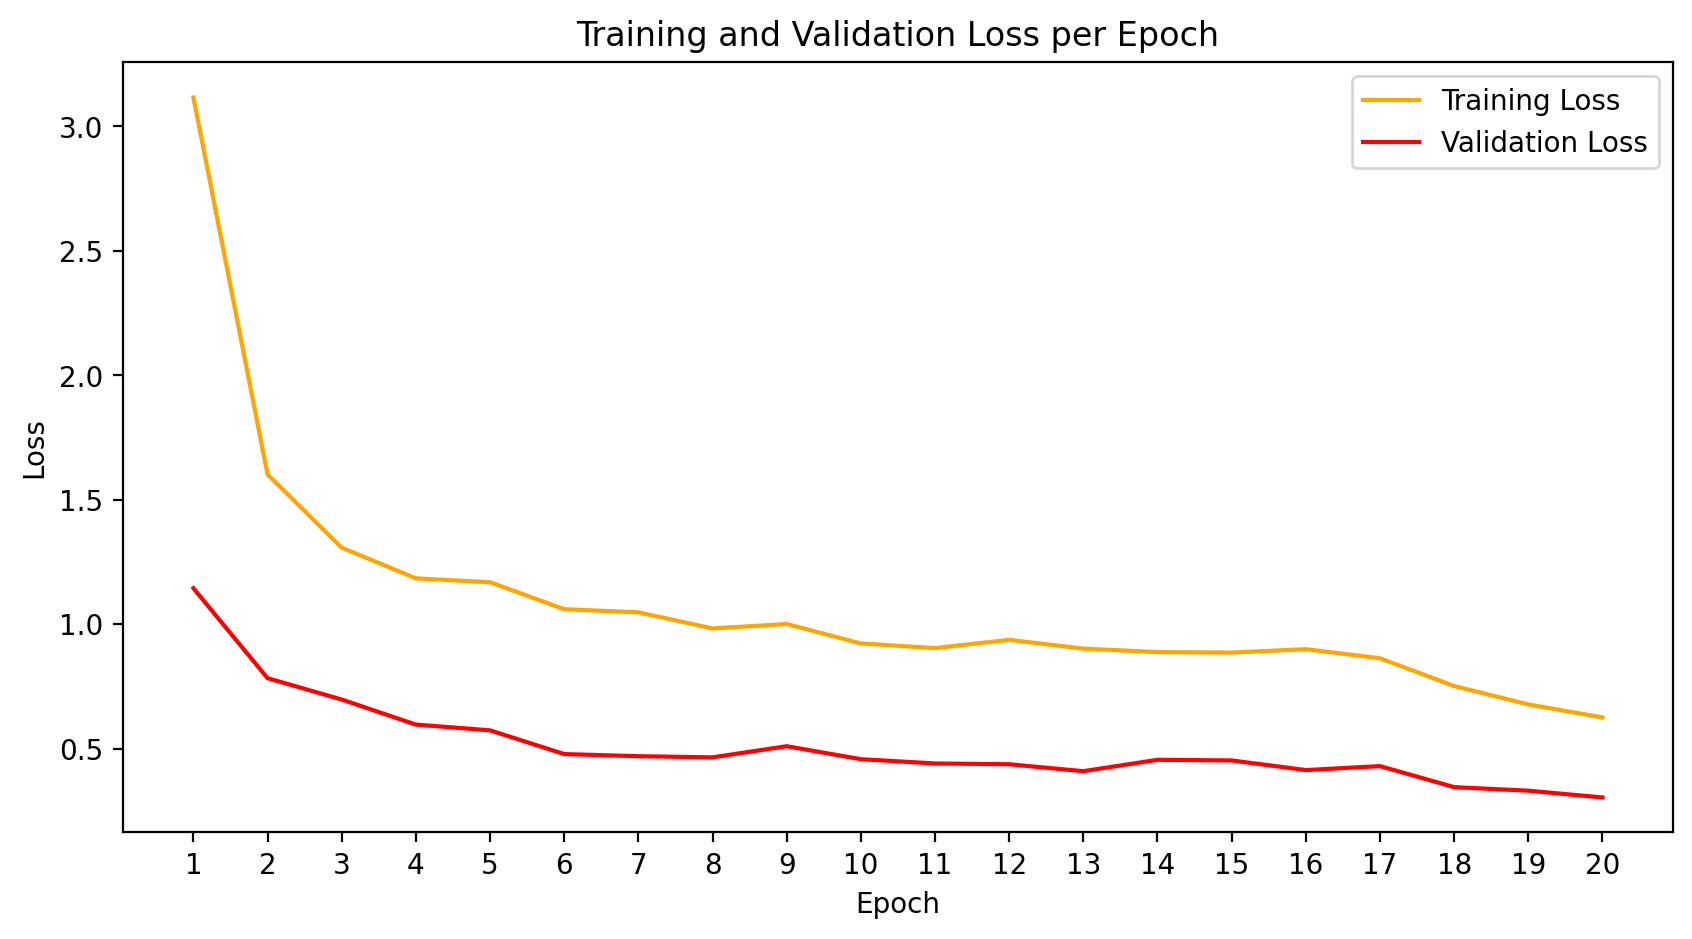

In [19]:
# Plot Training and Validation Losses
plot_and_save(
    data=[train_results['training_losses'], train_results['validation_losses']],
    x_range=range(1, train_params['epochs'] + 1),
    labels=["Training Loss", "Validation Loss"],
    xlabel="Epoch",
    ylabel="Loss",
    title="Training and Validation Loss per Epoch",
    file_path=os.path.join(base_dir, 'data', 'output', "training_and_validation_loss_per_epoch.png"),
    colors=["orange", "red"]
)

Figure saved at: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\output\validation_accuracy_perc_per_epoch.png


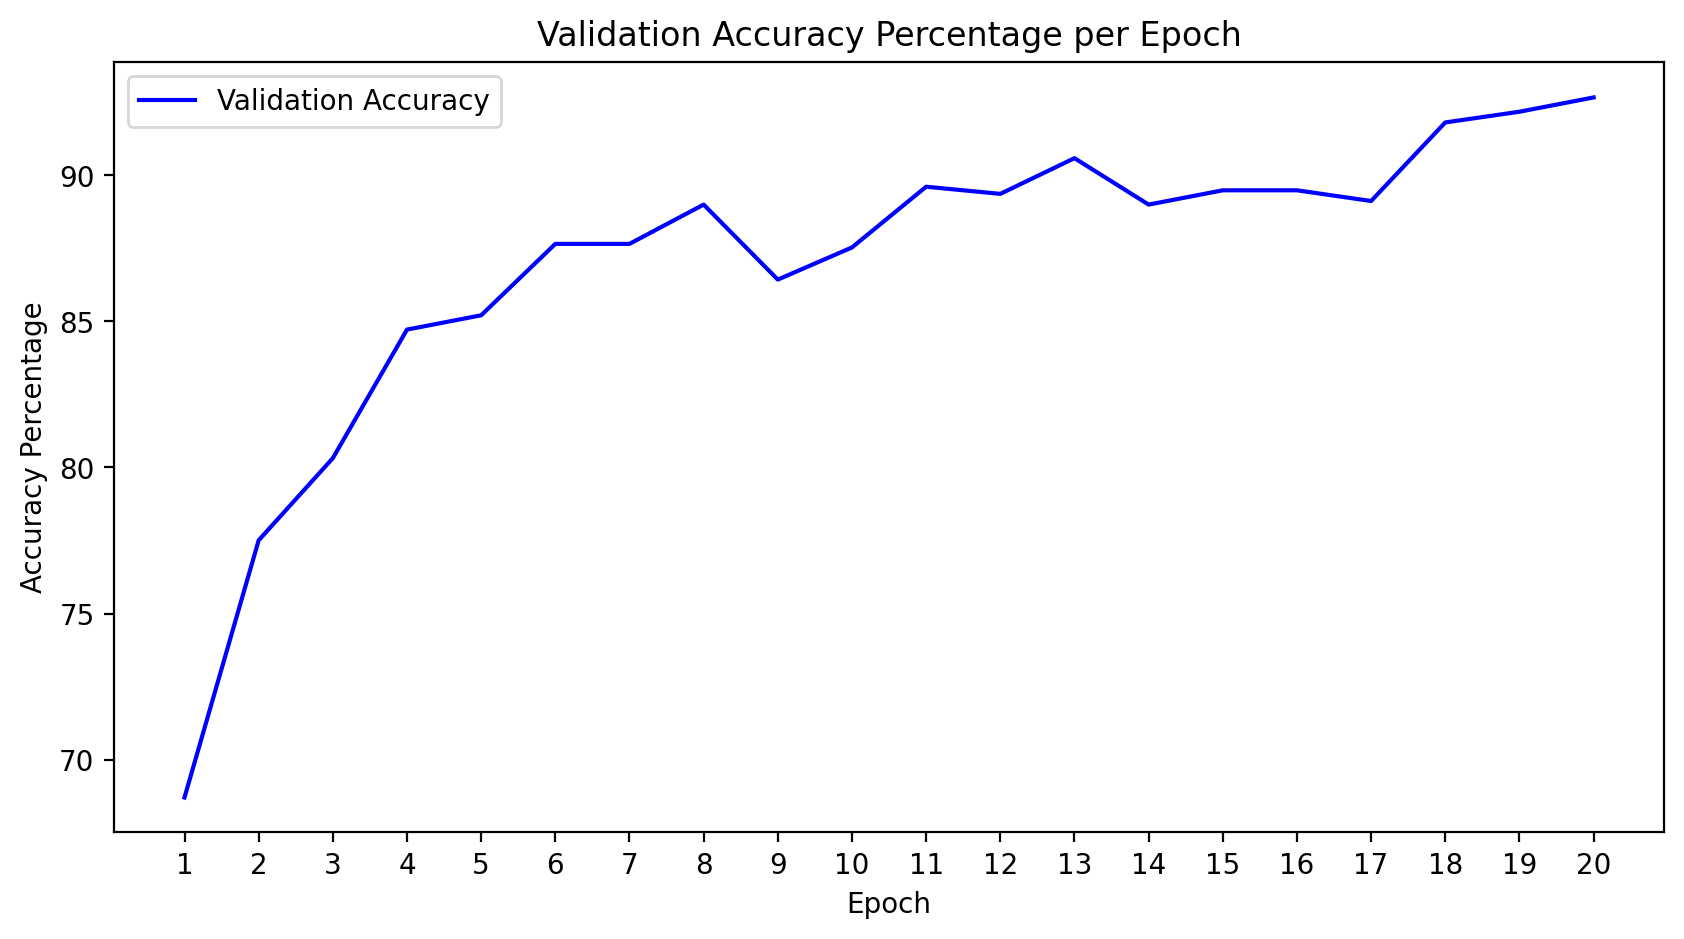

In [20]:
# Plot Validation Accuracies
plot_and_save(
    data=[train_results['validation_accuracies']],
    x_range=range(1, train_params['epochs'] + 1),
    labels=["Validation Accuracy"],
    xlabel="Epoch",
    ylabel="Accuracy Percentage",
    title="Validation Accuracy Percentage per Epoch",
    file_path=os.path.join(base_dir, 'data', 'output', "validation_accuracy_perc_per_epoch.png"),
    colors=["blue"]
)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
def validate_on_test_set(model, testingloader, criterion, device):
    """
    Validates the model on the test dataset and computes the average loss 
    and accuracy.

    Args:
        model (torch.nn.Module): The trained model to validate.
        testingloader (torch.utils.data.DataLoader): DataLoader for the test set.
        criterion (torch.nn.Module): Loss function to calculate the loss.
        device (torch.device): Device to run the computations on (CPU or GPU).

    Returns:
        dict: A dictionary containing:
            - 'testing_avg_loss': Average loss over the test dataset.
            - 'testing_accuracy': Accuracy of the model on the test dataset (%).
    """
    print("Start validation on the test set...")

    # Initialize variables for tracking loss and accuracy
    total_testing_loss = 0
    testing_correct_predictions = 0
    testing_total_predictions = 0

    # Set the model to evaluation mode (disables dropout layers)
    model.eval()

    # Disable gradient tracking for efficiency during validation
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(testingloader):
            print(f"Starting batch {idx + 1}/{len(testingloader)}...")

            # Move images and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: Compute predictions
            logps = model.forward(inputs)

            # Calculate the loss for the current batch
            batch_loss = criterion(logps, labels)

            # Add the current batch loss to the total testing loss
            total_testing_loss += batch_loss.item()

            # Calculate the accuracy for the current batch
            max_ps_values, predictions_labels = torch.max(logps, dim=1)
            equals = predictions_labels == labels.view(*predictions_labels.shape)

            # Update counts for correct predictions and total predictions
            testing_correct_predictions += equals.sum().item()
            testing_total_predictions += labels.shape[0]

            # Print batch summary
            print(
                f"Batch {idx + 1} summary: batch_loss={batch_loss:.2f}, "
                f"correct_predictions={testing_correct_predictions}, "
                f"total_predictions={testing_total_predictions}"
            )

    print("Finished validation on the test set...")

    # Calculate the average loss over all batches in the test set
    testing_avg_loss = total_testing_loss / len(testingloader)
    print(f"\nAverage loss per batch on the testing dataset is: {testing_avg_loss:.2f}")

    # Calculate the overall accuracy on the test dataset
    testing_accuracy = (testing_correct_predictions / testing_total_predictions) * 100
    print(f"Accuracy of the model on the testing dataset is: {testing_accuracy:.2f}%")

    # Return results as a dictionary
    return {
        'testing_avg_loss': testing_avg_loss,
        'testing_accuracy': testing_accuracy
    }


test_results = validate_on_test_set(model, testingloader, criterion, device)

Start validation on the test set...
Starting batch 1/13...
Batch 1 summary: batch_loss=0.61, correct_predictions=52, total_predictions=64
Starting batch 2/13...
Batch 2 summary: batch_loss=0.18, correct_predictions=112, total_predictions=128
Starting batch 3/13...
Batch 3 summary: batch_loss=0.38, correct_predictions=171, total_predictions=192
Starting batch 4/13...
Batch 4 summary: batch_loss=1.01, correct_predictions=223, total_predictions=256
Starting batch 5/13...
Batch 5 summary: batch_loss=0.08, correct_predictions=286, total_predictions=320
Starting batch 6/13...
Batch 6 summary: batch_loss=0.63, correct_predictions=338, total_predictions=384
Starting batch 7/13...
Batch 7 summary: batch_loss=0.16, correct_predictions=400, total_predictions=448
Starting batch 8/13...
Batch 8 summary: batch_loss=0.13, correct_predictions=463, total_predictions=512
Starting batch 9/13...
Batch 9 summary: batch_loss=0.09, correct_predictions=524, total_predictions=576
Starting batch 10/13...
Batch 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [22]:
def save_model_checkpoint(model_file_path, model, metadata):
    """
    Saves the trained model checkpoint along with metadata to a file.

    Args:
        model_file_path (str): The path to save the checkpoint file.
        model (torch.nn.Module): The trained model.
        metadata (dict): Dictionary containing metadata required to rebuild the model.
            Includes:
            - 'epochs' (int): Number of epochs the model was trained for.
            - 'testing_accuracy' (float): Accuracy achieved on the testing dataset.
            - 'learning_rate' (float): Learning rate used during training.
            - 'in_features_count' (int): Number of input features for the classifier.
            - 'hidden_units_count' (int): Number of hidden units in the classifier.
            - 'output_units_count' (int): Number of output units (classes).
            - 'class_to_idx' (dict): Mapping of classes to indices.

    Returns:
        None: Saves the checkpoint file to the specified path.
    """
    # Add the class_to_idx mapping to the model for future reference
    model.class_to_idx = metadata['class_to_idx']

    # Create the checkpoint dictionary
    checkpoint = {
        'state_dict': model.state_dict(),  # Model weights
        'epochs': metadata['epochs'],
        'testing_accuracy': metadata['testing_accuracy'],
        'learning_rate': metadata['learning_rate'],
        'in_features_count': metadata['in_features_count'],
        'hidden_units_count': metadata['hidden_units_count'],
        'output_units_count': metadata['output_units_count'],
        'class_to_idx': metadata['class_to_idx']
    }

    # Save the checkpoint to the specified file path
    torch.save(checkpoint, model_file_path)
    print("Model checkpoint saved to: {}".format(model_file_path))



# Define the path for saving the model checkpoint
model_file_path = os.path.join(
    base_dir, 
    'data', 
    'output', 
    'flora-vision-image-classifier-{:.0f}-checkpoint.pth'.format(test_results['testing_accuracy'])
)

# Create metadata for the checkpoint
checkpoint_metadata = {
    'epochs': train_params['epochs'],
    'testing_accuracy': test_results['testing_accuracy'],
    'learning_rate': train_params['learning_rate'],
    'in_features_count': model_in_features,
    'hidden_units_count': hidden_units,
    'output_units_count': output_units,
    'class_to_idx': training_dataset.class_to_idx
}

# Save the current model checkpoint
save_model_checkpoint(model_file_path, model, checkpoint_metadata)

Model checkpoint saved to: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\output\flora-vision-image-classifier-91-checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [23]:
def load_model_checkpoint(model_file_path, device):
    """
    Loads a model checkpoint and rebuilds the model.

    Args:
        model_file_path (str): Path to the saved model checkpoint.
        device (torch.device): The device (CPU or GPU) to load the model onto.

    Returns:
        torch.nn.Module: The loaded model with weights and metadata restored.
        dict: Metadata from the checkpoint.
    """
    # Load the checkpoint safely
    try:
        checkpoint = torch.load(model_file_path, map_location=device, weights_only=True)
    except Exception as e:
        raise RuntimeError(f"Failed to load checkpoint: {e}")

    # Extract required metadata for model rebuilding
    in_features_count = checkpoint.get('in_features_count')
    hidden_units_count = checkpoint.get('hidden_units_count')
    output_units_count = checkpoint.get('output_units_count')
    dropout_rate = checkpoint.get('dropout_rate', 0.3)

    # Rebuild the model
    model = build_custom_model(
        model_in_features=in_features_count,
        hidden_units=hidden_units_count,
        output_units=output_units_count,
        dropout_rate=dropout_rate
    )

    # Load the model's state dictionary
    model.load_state_dict(checkpoint['state_dict'])

    # Restore class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Set the model to evaluation mode
    model.eval()

    # Move model to device
    model.to(device)

    # Extract and return metadata
    metadata = {k: checkpoint[k] for k in checkpoint if k != 'state_dict'}
    print(f"Model loaded with metadata: {metadata}")
    return model, metadata


# Load the model with the trained weights
loaded_model, model_metadata = load_model_checkpoint(model_file_path, device)

# Print class-to-index mapping
print("\n\nclass_to_idx: {}".format(json.dumps(loaded_model.class_to_idx, indent=4)))

Loaded pre-trained VGG16 model successfully...
Feature extractor layers frozen...
Custom classifier built and replaced the original classifier...
Model loaded with metadata: {'epochs': 20, 'testing_accuracy': 90.84249084249085, 'learning_rate': 0.001, 'in_features_count': 25088, 'hidden_units_count': 4096, 'output_units_count': 102, 'class_to_idx': {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [24]:
def process_image(image_path, transform=None):
    """
    Processes a PIL image for use in a PyTorch model by scaling, cropping,
    and normalizing the image.

    Args:
        image_path (str): Path to the image file.
        transform (torchvision.transforms.Compose, optional): Transformation pipeline 
            to be applied to the image. If None, default testing transformations are used.

    Returns:
        torch.Tensor: Transformed image tensor ready for model input.
    """
    # Load the image from the specified path
    try:
        input_image = Image.open(image_path)
    except Exception as e:
        raise RuntimeError(f"Failed to load image from {image_path}: {e}")

    # Use the provided transform or default to testing transforms
    if transform is None:
        transform = get_testing_transforms()

    # Apply the transformations
    output_image = transform(input_image)

    # Return the processed image tensor
    return output_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [25]:
def get_random_test_image_path(base_dir, test_subdir="test", extensions=("*.jpg", "*.png")):
    """
    Retrieves the absolute path of a random image from the test dataset directory.

    Args:
        base_dir (str): The base directory containing the dataset.
        test_subdir (str, optional): Subdirectory name for the test images. Default is "test".
        extensions (tuple, optional): File extensions to search for. Default is ("*.jpg", "*.png").

    Returns:
        str: Absolute path of a randomly selected test image.

    Raises:
        FileNotFoundError: If no matching image files are found in the test directory.
    """
    # Define the test directory path
    test_dir = os.path.join(base_dir, "data", "flowers", test_subdir)

    # Collect all image paths matching the specified extensions recursively
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(test_dir, "**", ext), recursive=True))

    # Raise an error if no images were found
    if not image_paths:
        raise FileNotFoundError(
            f"No image files with extensions {extensions} found in the '{test_dir}' directory."
        )

    # Select and return a random image path
    return os.path.abspath(random.choice(image_paths))

Test image path is: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\flowers\test\73\image_00445.jpg


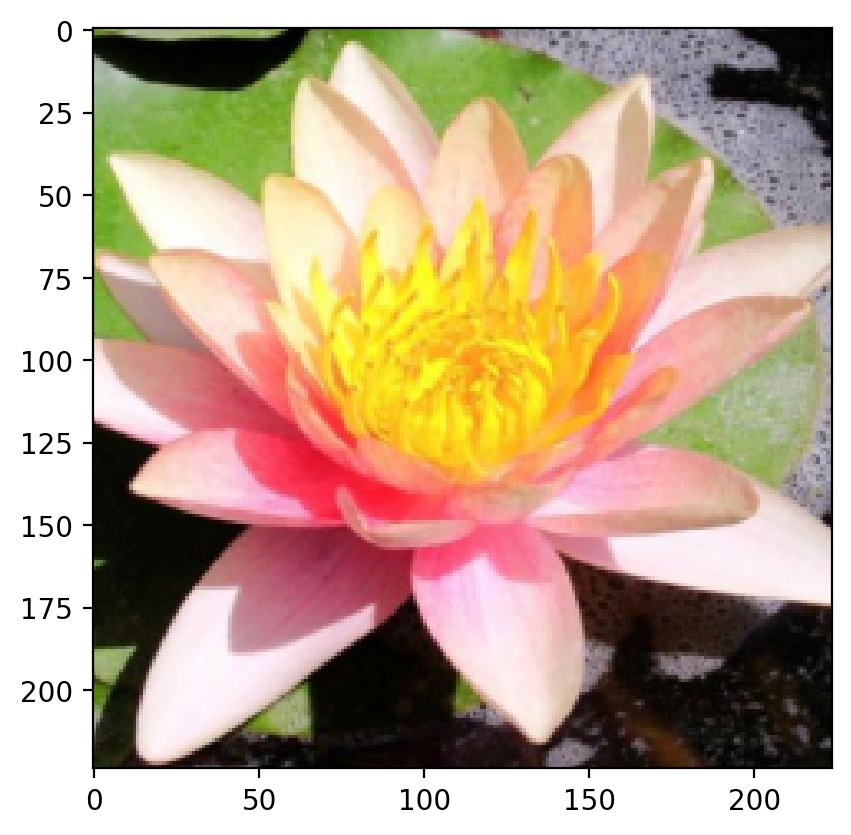

In [26]:
def display_image(image_tensor, ax=None, title=None):
    """
    Displays a processed PyTorch tensor as an image using matplotlib.

    Args:
        image_tensor (torch.Tensor): The image tensor to display. Assumes the 
                                      tensor is normalized and has shape (C, H, W).
        ax (matplotlib.axes._axes.Axes, optional): Matplotlib Axes object. If None, 
                                                   a new figure and Axes will be created.
        title (str, optional): Title of the image plot.

    Returns:
        matplotlib.axes._axes.Axes: Axes object with the image displayed.
    """
    # Create a new figure and Axes if none are provided
    if ax is None:
        fig, ax = plt.subplots()

    # Convert PyTorch tensor to NumPy array and adjust dimensions for matplotlib
    image = image_tensor.numpy().transpose((1, 2, 0))

    # Undo preprocessing (de-normalize the image)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip image values between 0 and 1 to prevent display artifacts
    image = np.clip(image, 0, 1)

    # Display the image
    ax.imshow(image)

    # Set the title if provided
    if title:
        ax.set_title(title)

    return ax


def test_display_processed_image(base_dir):
    """
    Tests the process_image function by processing a random test image and displaying it.

    Args:
        base_dir (str): The base directory containing the dataset.

    Returns:
        None
    """
    # Select a random test image
    random_test_image_path = get_random_test_image_path(base_dir)
    print("Test image path is: {}".format(random_test_image_path))

    # Process the selected test image into a tensor
    test_tensor_image = process_image(image_path=random_test_image_path)

    # Display the processed image
    display_image(image_tensor=test_tensor_image)


# Test the display_image function
test_display_processed_image(base_dir)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [27]:
def invert_class_to_idx(class_to_idx):
    """
    Inverts a class_to_idx dictionary to create an idx_to_class mapping.

    Args:
        class_to_idx (dict): A dictionary mapping class labels (e.g., category names as strings)
                             to indices (e.g., integers).

    Returns:
        dict: An inverted dictionary mapping indices back to class labels.

    Raises:
        ValueError: If the provided `class_to_idx` is not a dictionary.
    """
    if not isinstance(class_to_idx, dict):
        raise ValueError("The provided class_to_idx must be a dictionary.")

    # Invert the mapping
    return {v: k for k, v in class_to_idx.items()}


def get_true_indices(idx_to_class, indices_list):
    """
    Maps indices to their corresponding class labels using idx_to_class.

    Args:
        idx_to_class (dict): A dictionary mapping indices to class labels.
        indices_list (list): A list of indices to be converted.

    Returns:
        list: A list of class labels corresponding to the indices.
    """
    return [idx_to_class[index] for index in indices_list]


def map_index_to_category(cat_to_name, index):
    """
    Maps a given index to its corresponding category name.

    Args:
        cat_to_name (dict): A dictionary mapping class labels to category names.
        index (str): The index of the category to be mapped.

    Returns:
        str: The name of the category corresponding to the given index.
    """
    return cat_to_name[index]


def predict(image_path, model, cat_to_name, idx_to_class, topk=5):
    """
    Predicts the top K classes and their probabilities for a given image using a trained model.

    Args:
        image_path (str): The file path of the image to predict.
        model (torch.nn.Module): The trained deep learning model.
        cat_to_name (dict): A dictionary mapping class labels to category names.
        idx_to_class (dict): A dictionary mapping indices to class labels.
        topk (int, optional): The number of top predictions to return. Defaults to 5.

    Returns:
        tuple: A tuple containing two lists:
               - top_labels (list of str): The names of the top predicted categories.
               - top_ps_perc (list of float): The probabilities of the top predicted categories in percentages.
    """
    # Set model to evaluation mode
    model.eval()

    # Determine the device of the model
    device = next(model.parameters()).device

    # Process the image and move it to the correct device
    processed_image = process_image(image_path).to(device).unsqueeze(0)

    # Perform forward pass through the model without tracking gradients
    with torch.no_grad():
        y_hat_logps = model(processed_image)

    # Convert the output log-probabilities to probabilities
    y_hat_ps = torch.exp(y_hat_logps)

    # Get the top-k probabilities and indices
    top_ps, top_indices = y_hat_ps.topk(topk, dim=1)

    # Convert tensors to lists
    top_ps = top_ps.flatten().tolist()
    top_indices = top_indices.flatten().tolist()

    # Map indices to their actual class labels
    true_top_indices = get_true_indices(idx_to_class, indices_list=top_indices)

    # Map class labels to their category names
    top_labels = [map_index_to_category(cat_to_name, x) for x in true_top_indices]

    # Convert probabilities to percentages
    top_ps_perc = [round(ps * 100, 2) for ps in top_ps]

    # Debug print statements
    print("Top indices are: {}".format(true_top_indices))
    print("Top labels are: {}".format(top_labels))
    print("Top probabilities are: {}".format(top_ps_perc))

    return top_labels, top_ps_perc


# Invert class_to_idx to create idx_to_class mapping
idx_to_class = invert_class_to_idx(loaded_model.class_to_idx)

# Select random image to test
random_test_image_path = get_random_test_image_path(base_dir)
print("Test image path is: {}".format(random_test_image_path))

# Predict the top labels and probabilities for the random image
top_labels, top_ps_perc = predict(
    image_path=random_test_image_path,
    model=loaded_model,
    cat_to_name=cat_to_name,
    idx_to_class=idx_to_class
)

Test image path is: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\flowers\test\6\image_07181.jpg
Top indices are: ['6', '102', '2', '77', '80']
Top labels are: ['tiger lily', 'blackberry lily', 'hard-leaved pocket orchid', 'passion flower', 'anthurium']
Top probabilities are: [100.0, 0.0, 0.0, 0.0, 0.0]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='data/assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Test image path is: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\flowers\test\56\image_02772.jpg
Top indices are: ['56', '41', '99', '44', '71']
Top labels are: ['bishop of llandaff', 'barbeton daisy', 'bromelia', 'poinsettia', 'gazania']
Top probabilities are: [99.08, 0.69, 0.05, 0.05, 0.02]
Figure saved at: D:\Repos\flora-vision-image-classifier\flora_vision_image_classifier\data\output\prediction_with_image.png


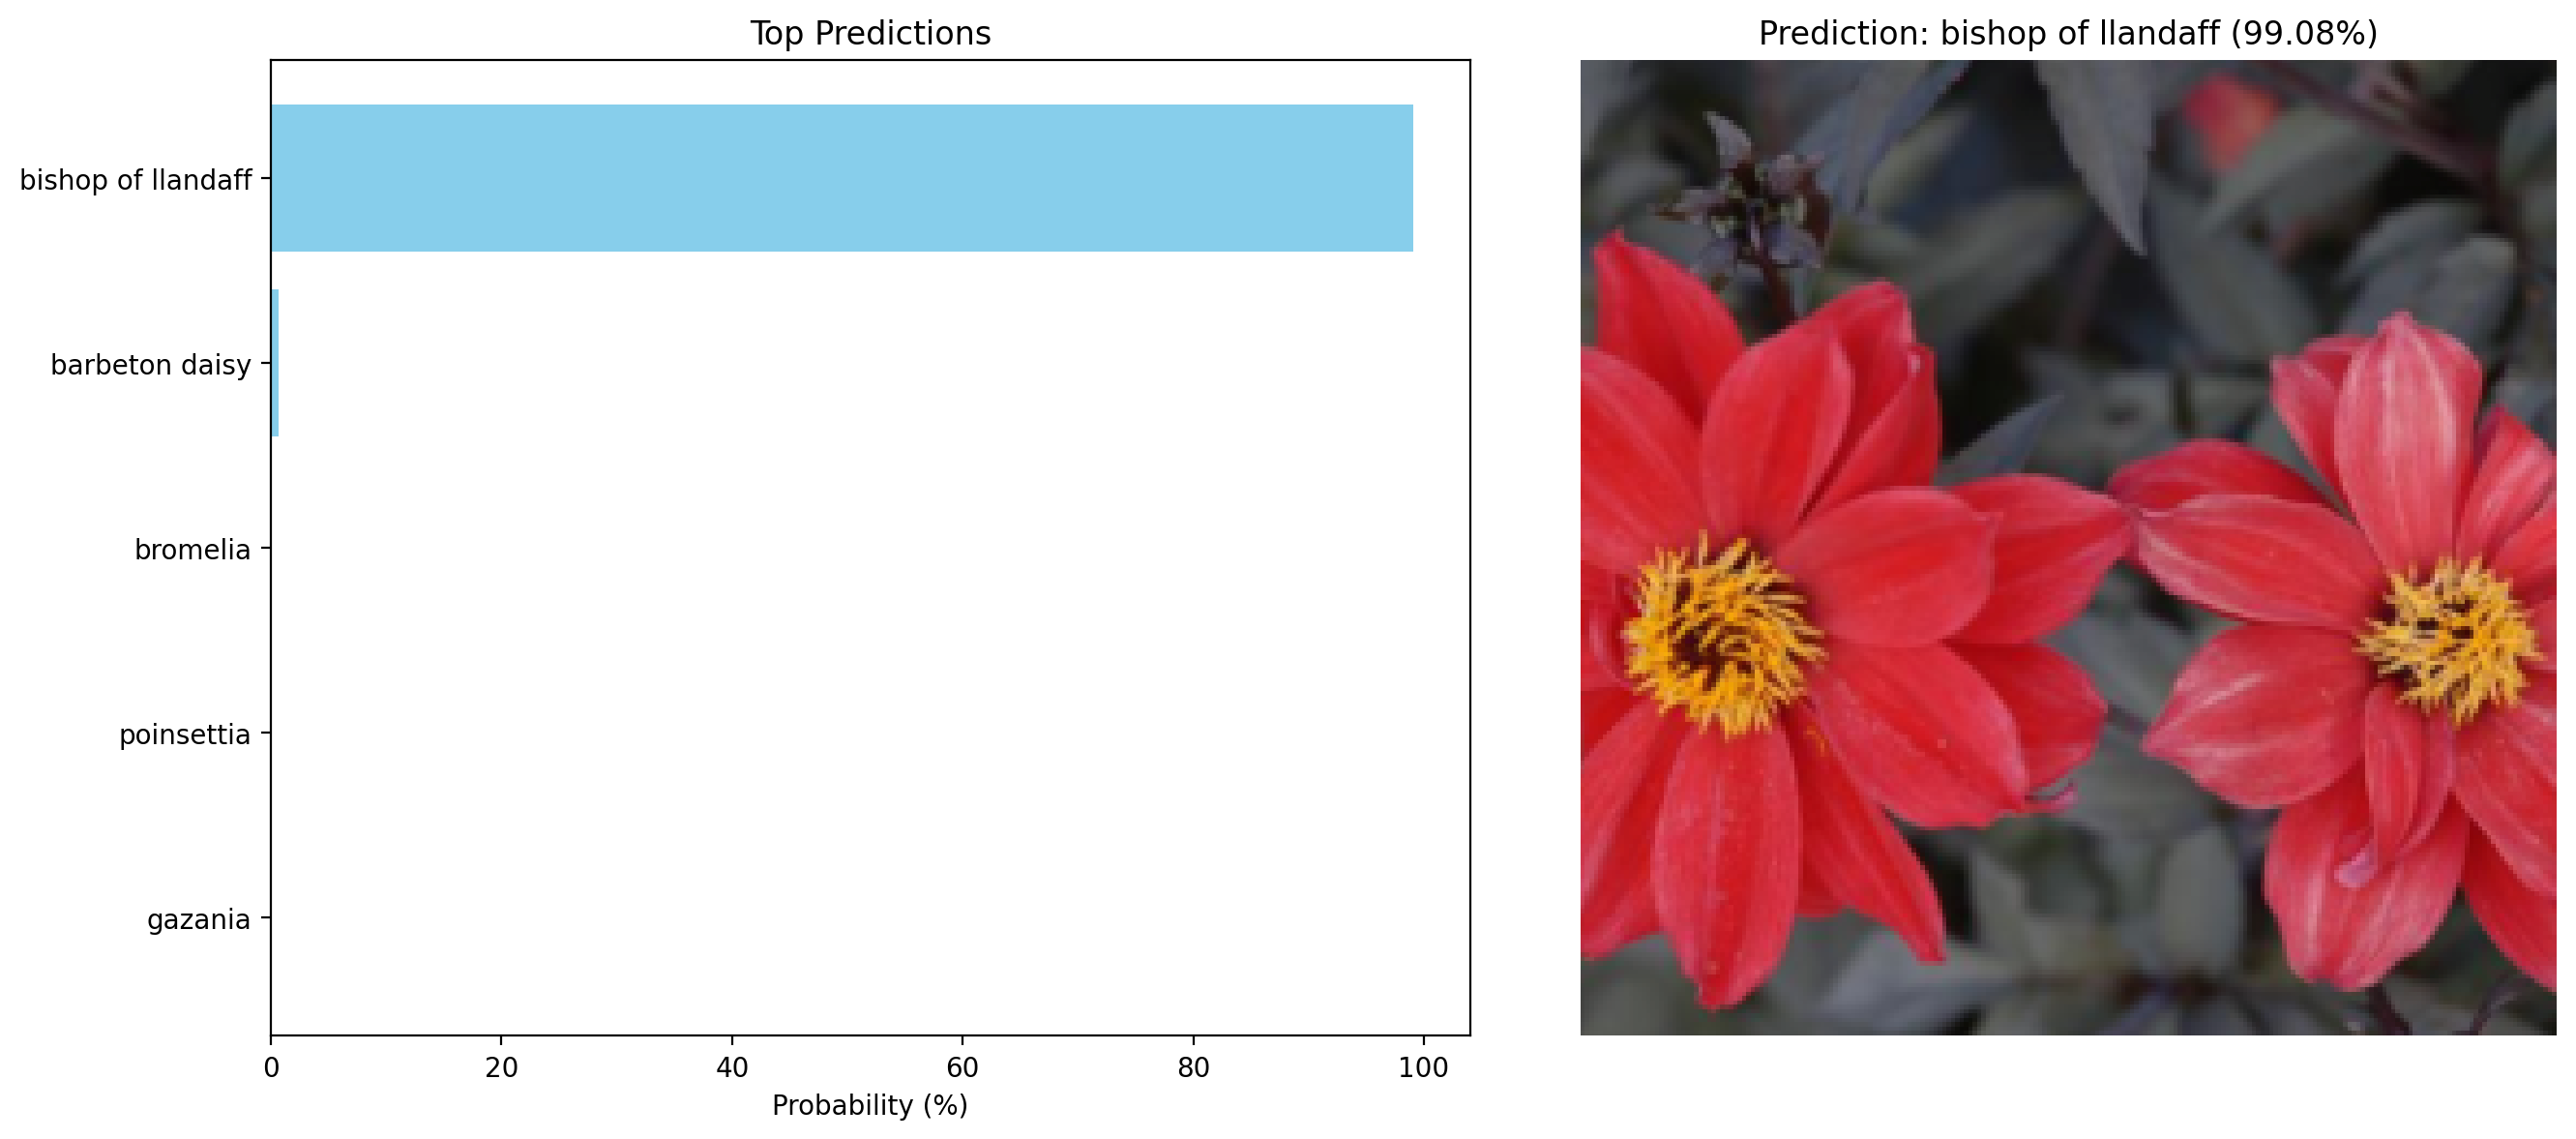

In [29]:
def display_image_with_predictions(image_path, model, cat_to_name, idx_to_class, topk=5):
    """
    Displays an image alongside the top K predicted classes and their probabilities.

    Args:
        image_path (str): Path to the image to be displayed and predicted.
        model (torch.nn.Module): The trained deep learning model.
        cat_to_name (dict): A dictionary mapping class labels to category names.
        idx_to_class (dict): A dictionary mapping indices to class labels.
        topk (int, optional): Number of top predictions to display. Defaults to 5.

    Returns:
        None
    """
    # Predict top labels and probabilities
    top_labels, top_ps_perc = predict(
        image_path=image_path,
        model=model,
        cat_to_name=cat_to_name,
        idx_to_class=idx_to_class,
        topk=topk
    )

    # Display the image and predictions
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 6))  # Swap axes: ax2 is now for predictions

    # Display the top predictions as a horizontal bar chart
    ax2.barh(top_labels, top_ps_perc, color='skyblue')
    ax2.set_xlabel("Probability (%)")
    ax2.set_title("Top Predictions")
    ax2.invert_yaxis()  # Invert the y-axis to display the highest probability on top

    # Show the image
    image_tensor = process_image(image_path)
    display_image(
        image_tensor=image_tensor,
        ax=ax1,
        title="Prediction: {} ({}%)".format(top_labels[0], top_ps_perc[0])
    )
    ax1.axis("off")  # Turn off axis display for the image

    # Save the combined figure to the desired directory
    fig_path = os.path.join(
        base_dir, 'data', 'output', "prediction_with_image.png"
    )
    plt.savefig(fig_path)
    print("Figure saved at: {}".format(fig_path))

    # Display the figure
    plt.tight_layout()
    plt.show()


# Select a random image from the test set
random_test_image_path = get_random_test_image_path(base_dir)
print("Test image path is: {}".format(random_test_image_path))

# Display the selected image with its top predictions
display_image_with_predictions(
    image_path=random_test_image_path,
    model=loaded_model,
    cat_to_name=cat_to_name,
    idx_to_class=idx_to_class,
    topk=5
)